<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introdu√ß√£o-e-Cen√°rio" data-toc-modified-id="Introdu√ß√£o-e-Cen√°rio-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introdu√ß√£o e Cen√°rio</a></span><ul class="toc-item"><li><span><a href="#Objetos-e-Elementos-do-Projeto" data-toc-modified-id="Objetos-e-Elementos-do-Projeto-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Objetos e Elementos do Projeto</a></span></li></ul></li><li><span><a href="#Criando-um-Bucket-S3" data-toc-modified-id="Criando-um-Bucket-S3-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Criando um Bucket S3</a></span><ul class="toc-item"><li><span><a href="#Via-Console" data-toc-modified-id="Via-Console-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Via Console</a></span></li><li><span><a href="#Via-boto3" data-toc-modified-id="Via-boto3-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Via boto3</a></span></li></ul></li></ul></div>

# Introdu√ß√£o e Cen√°rio

Este notebook tem por objetivo documentar e detalhar os passos realizados para a utiliza√ß√£o do servi√ßo **S3** (do ingl√™s, _Simple Storage Service_) da AWS para o armazenamento de objetos gerados pelas funcionalidades do projeto [nbaflow](https://github.com/ThiagoPanini/nbaflow). Dentro da proposta de migra√ß√£o do projeto para uma arquitetura em nuvem, no notebook [NBAFlow-aws-migration](https://github.com/ThiagoPanini/nbaflow/blob/main/notebooks/NBAFlow-aws-migration.ipynb) foi proposta uma documenta√ß√£o completa sobre todas as etapas realizadas dentro do processo de utiliza√ß√£o de um servi√ßo de banco de dados relacional (RDS) conectado a um servi√ßo computacional (EC2) para consultar dados de jogadores da NBA e, eventualmente, entreg√°-los por e-mail ao usu√°rio.

Como resultado dessa frente de migra√ß√£o, foi poss√≠vel alcan√ßar a seguinte arquitetura j√° testada e validada dentro dos prop√≥sitos iniciais estabelecidos:

<div align="center">
    <br><img src="https://i.imgur.com/8uRYLEH.png" alt="aws_diagram">
</div>

Na pr√°tica, a inst√¢ncia EC2 possui scripts python clonados do reposit√≥rio oficial do projeto no GitHub via SSH e, a partir deles, o desenvolvedor pode manualmente solicitar a execu√ß√£o para dois prop√≥sitos espec√≠ficos:

* _**insert_gamelog_data.py**_: l√™ um arquivo csv processado previamente e disponibilizado no diret√≥rio `data/` para realizar um processo de cria√ß√£o de tabela e ingest√£o de dados em um banco de dados RDS PostgreSQL.
* _**player_gamelog_from_db.py**_: recebe par√¢metros do usu√°rio no prompt de comando (nome de um jogador e temporada v√°lida da NBA) para construir uma query de consulta a ser executada no banco de dados. Os dados s√£o retornados em um formato DataFrame e, opcionalmente, enviados por e-mail para um destinat√°rio fornecido tamb√©m manualmente.

<div class="alert alert-block alert-info">
<b>Observa√ß√£o:</b> At√© este ponto, ainda n√£o foi poss√≠vel construir uma l√≥gica inteiramente voltada √† APIs. Em outras palavras, todas as itera√ß√µes usu√°rio-c√≥digo s√£o feitas diretamente pelo prompt de comando e, futuramente, a ideia √© que essa comunica√ß√£o seja feita a partir de uma rota espec√≠fica onde o usu√°rio possa acessar e enviar suas solicita√ß√µes de acordo com os filtros desejados. Al√©m disso, ainda existem oportunidades de otimizar esse fluxo a partir da utiliza√ß√£o de outros servi√ßos da AWS capazes de servir como um alicerce computacional como, por exemplo, fun√ß√µes lambda.
</div>

___
**_Para entender todo o contexto do projeto, √© sugerido o consumo dos seguintes materiais:_**

* [1. NBAFlow - documenta√ß√£o e explora√ß√£o inicial da API nba_api](https://github.com/ThiagoPanini/nbaflow/blob/main/notebooks/NBAflow-doc-api.ipynb)

* [2. NBAFlow - documenta√ß√£o de fluxo de extra√ß√£o de imagens de jogadores](https://github.com/ThiagoPanini/nbaflow/blob/main/notebooks/NBAflow-players-images.ipynb)

* [3. NBAFlow - estrutura√ß√£o de armazenamento em banco de dados Postgres (OPCIONAL)](https://github.com/ThiagoPanini/nbaflow/blob/main/notebooks/NBAflow-psql.ipynb)

* [4. NBAFlow - primeiros passos da migra√ß√£o para a AWS](https://github.com/ThiagoPanini/nbaflow/blob/main/notebooks/NBAFlow-aws-migration.ipynb)

* [5. Classes estruturadas de processamento de dados](https://github.com/ThiagoPanini/nbaflow/tree/main/core)

* [6. Scripts de processamento de dados utilizando as classes estruturadas](https://github.com/ThiagoPanini/nbaflow/tree/main/scripts)
___

## Objetos e Elementos do Projeto

Assim, em paralelo aos desafios acima explicados e, dentro dos objetivos estabelecidos no in√≠cio deste material, a grande explora√ß√£o a ser realizada nas pr√≥xima se√ß√µes gira em torno da utiliza√ß√£o do servi√ßo S3 para o armazenamento de alguns objetos presentes em momentos espec√≠ficos do fluxo de trabalho do projeto NBAFlow. 

Neste cen√°rio, os objetos citados referem-se a:

* **_Arquivos de dados_**: ao longo do desenvolvimento do projeto, foram criados scripts de requisi√ß√£o e processamento de dados de jogadores da NBA para serem analisados posteriormente. Neste prop√≥sito, o m√≥dulo [`gamelog`](https://github.com/ThiagoPanini/nbaflow/blob/main/core/gamelog.py) foi concebido como uma forma de centralizar o consumo do pacote [nba_api](https://github.com/swar/nba_api) no univero de an√°lise de partidas e estat√≠sticas individuais de jogadores da liga em todas as temporadas dispon√≠veis. Ao longo do processamento, notou-se uma carga excessiva de requisi√ß√µes realizadas, gerando assim um alto tempo de execu√ß√£o para o retorno dos dados de todas as partidas, de todos os jogadores, em todas as temporadas v√°lidas. Assim, visando otimizar as etapas posteriores, todo o hist√≥rico processado foi armazenado no arquivo [all_players_gamelog.csv](https://github.com/ThiagoPanini/nbaflow/blob/main/data/all_players_gamelog.csv) contendo todos os insumos necess√°rios para uma an√°lise completa da liga. Exemplificando a utilidade deste arquivo, o script [`insert_gamelog_data`](https://github.com/ThiagoPanini/nbaflow/blob/main/scripts/db_integration/insert_gamelog_data.py) se utiliza deste arquivo csv para inserir registros em uma tabela em um banco de dados PostgreSQL (local ou na nuvem). Como um passo adicional, neste material ser√° proposto o armazenamento deste arquivo em um bucket do S3 para consumo direto via script. Eventualmente, ser√° poss√≠vel adicionar l√≥gicas no m√≥dulo `gamelog` para salvar os resultados das requisi√ß√µes √† nba_api direto em buckets do S3 utilizando o SDK [`boto3`](https://boto3.amazonaws.com/v1/documentation/api/latest/guide/quickstart.html).


* **_Imagens de jogadores_**: em uma outra frente extremamente relevante dentro do projeto NBAFlow, foi constru√≠da uma l√≥gica capaz de extrair imagens de alta qualidade dos jogadores da NBA diretamente do [site oficial](https://www.nba.com/stats/). Neste cen√°rio, o m√≥dulo [`images`](https://github.com/ThiagoPanini/nbaflow/blob/main/core/images.py) foi concebido como uma forma de centralizar os elementos necess√°rios para a consolida√ß√£o dessas requisi√ß√µes e o salvamento local dos arquivos png recebidos no sistema operacional. Como alternativas, ser√° proposta a inclus√£o dessas imagens em um bucket do S3 para um armazenamento mais sustent√°vel dentro das propostas gerais do projeto. Eventualmente, ser√° poss√≠vel aplicar algumas altera√ß√µes no m√≥dulo `images` para que as imagens obtidas pelas requisi√ß√µes j√° sejam automaticamente salvas em buckets do S3. Para tal, mais uma vez, ser√° preciso utilizar as funcionalidade so SDK `boto3`.

# Criando um Bucket S3

Iniciando as etapas pr√°ticas de constru√ß√£o dos elementos propostos, em um primeiro momento, ser√£o detalhados os passos para a cria√ß√£o de um (ou mais de um) bucket S3 pela AWS utilizando o console de gerenciamento. Posteriormente, um primeiro contato com o SDK `boto3` ser√° fornecido como uma forma eficiente de automatizar, organizar e gerenciar recursos da AWS utilizando a linguagem Python.

## Via Console

Conforme mencionado acima, as primeiras itera√ß√µes com o servi√ßo S3 ser√£o obtidas a partir do console de gerenciamento da AWS. Nesse formato, a [p√°gina do servi√ßo](https://console.aws.amazon.com/s3/home?region=sa-east-1) foi utilizada para a cria√ß√£o de um novo bucket denominado `nbaflow-console`. Nele, dois novos [diret√≥rios](https://docs.aws.amazon.com/AmazonS3/latest/userguide/using-folders.html) foram criados para armazenar _dados_ (arquivos em geral) e _imagens_.

> üìå**Nota**: de acordo com a documenta√ß√£o oficial, no S3, buckets e objetos s√£o os recursos principais, sendo os objetos armazenados em buckets. Mesmo sem o mesmo significado dos sistemas operacionais, √© poss√≠vel criar "diret√≥rios" nos buckets para fins organizacionais, facilitando assim as refer√™ncias e o armazenamento de objetos. O conceito fundamental de diret√≥rios no S3 √© o de simplesmente agrupar objetos a partir de um prefixo adicionado √† rota do objeto.

A imagem abaixo traz o bucket `nbaflow-console` criado com os diret√≥rios `data/` e `imgs/` associados:

<div align="center">
    <br><img src="https://i.imgur.com/geU2QZE.png" alt="s3_bucket_nbaflow-console">
</div>

Na sequ√™ncia, tamb√©m utilizando as funcionalidades do console, foram realizados os uploads do arquivo `all_players_gamelog.csv` e das imagens png originalmente armazenadas no diret√≥rio `data/images/players` do reposit√≥rio do projeto. A imagem abaixo traz um exemplo do diret√≥rio `imgs/` do bucket rec√©m criado j√° com as imagens de jogadores armazenadas.

<div align="center">
    <br><img src="https://i.imgur.com/0s9jFyP.png" alt="s3_imgs">
</div>

Dessa forma, em um processo altamente intuitivo, foi poss√≠vel finalizar essa primeira etapa de cria√ß√£o de bucket a partir do console de gerenciamento da AWS. Al√©m disso, o upload dos arquivos selecionados foram realizados dentro dos diret√≥rios criados no bucket. A cria√ß√£o do bucket e o upload dos arquivos foram realizados seguindos todas as configura√ß√µes padr√£o propostas no processo o que, em resumo, podem ser descritadas como:

* Bucket criado sem acesso p√∫blico
* Bucket criado sem versionamento
* Bucket sem encripta√ß√£o dos dados
* Acesso de leitura e escrita aos objetos est√° restrito ao owner do bucket

Na pr√≥xima se√ß√£o, os processos de cria√ß√£o, configura√ß√£o e upload de objetos no bucket ser√£o realizados a partir do SDK Python `boto3`.

## Via boto3

De acordo com a [p√°gina oficial de documenta√ß√£o](https://boto3.amazonaws.com/v1/documentation/api/latest/index.html), o SDK `boto3` pode ser resumido a:

> _You use the AWS SDK for Python (Boto3) to create, configure, and manage AWS services, such as Amazon Elastic Compute Cloud (Amazon EC2) and Amazon Simple Storage Service (Amazon S3). The SDK provides an object-oriented API as well as low-level access to AWS services._

Considerando a riqueza de detalhes e de exemplos fornecidos pela pr√≥pria AWS, grande parte dos primeiros passos aqui documentados ser√£o reprodu√ß√µes adaptadas da p√°gina oficial de documenta√ß√£o. Para tal, visando alinhar os prop√≥sitos deste notebook, √© sugerido que o usu√°rio consumidor do material aqui presente siga algumas instru√ß√µes b√°sicas de configura√ß√£o propostas pela documenta√ß√£o do boto3 para que os c√≥digos aqui escritos tenham a efic√°cia planejada.

Assim, depois de um breve estudo no material oficial, a instala√ß√£o do boto3 foi feita, dentro do ambiente virtual criado para o projeto NBAFLow, atrav√©s do comando:

    pip install boto3
    
Mesmo ap√≥s a instala√ß√£o, as primeiras tentativas de uso do SDK n√£o foram bem sucedidas. Isto porque, de maneira direta, o boto3 necessita encontrar (ou ser devidamente configurado para isso) credenciais v√°lidas do usu√°rio para que as opera√ß√µes possam ser realizadas. Dessa forma, com a instala√ß√£o do [AWS CLI](https://aws.amazon.com/pt/cli/) e a execu√ß√£o do comando `aws configure`, foi poss√≠vel providenciar os insumos necess√°rios para que o boto3 consiga autenticar o usu√°rio dentro da utiliza√ß√£o dos recursos na nuvem. Para detalhes adicionais, pode-se analisar a se√ß√£o de [Configura√ß√£o](https://boto3.amazonaws.com/v1/documentation/api/latest/guide/quickstart.html#configuration) da documenta√ß√£o oficial.

Por fim, as linhas de c√≥digo abaixo trazem a importa√ß√£o da biblioteca boto3 juntamente com a cria√ß√£o de um recurso "s3" utilizado para gerenciar e automatizar a√ß√µes dentro deste servi√ßo de armazenamento. Como valida√ß√£o, ser√£o mostrados todos os buckets presentes na conta AWS configurada.

In [5]:
# Importando biblioteca
import boto3

# Criando recurso e listando buckets
s3 = boto3.resource('s3')
for bucket in s3.buckets.all():
    print(bucket.name)

nbaflow-console


De fato, com o c√≥digo acima, foi poss√≠vel verificar que existe apenas um bucket criado na conta configurada da AWS (o rec√©m criado *nbaflow-console*). Ainda nessas primeiras intera√ß√µes com boto3 e buckets S3, o c√≥digo abaixo √© respons√°vel por conectar a um bucket e ler um objeto diretamente na mem√≥ria. Neste caso, ser√° proposta a leitura de uma das imagens de jogadores da NBA utilizando uma `key` espec√≠fica que contempla, como prefixo, o diret√≥rio criado manualmente no bucket para organiza√ß√£o do armazenamento.

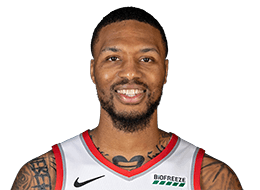

In [23]:
from PIL import Image
from io import BytesIO

# Vinculando bucket alvo
bucket = s3.Bucket('nbaflow-console')

# Coletando objeto
obj = bucket.Object(key='imgs/Damian Lillard.png')
response = obj.get()
file_stream = response['Body']
Image.open(file_stream)

**_Refer√™ncia:_** https://stackoverflow.com/questions/44043036/how-to-read-image-file-from-s3-bucket-directly-into-memory

At√© este ponto, j√° √© poss√≠vel mensurar o poder fornecido pelo SDK boto3 dentro das possibilidades de gerenciamento de recursos na AWS. Com ele, foi poss√≠vel ler diretamente na mem√≥ria um objeto armazenado manualmente em um bucket s3 criado diretamente pelo console. Considerando esta atua√ß√£o, o bloco de c√≥digo abaixo ir√° propor a cria√ß√£o de um **novo bucket** S3 em uma regi√£o espec√≠fica para que, futuramente, este c√≥digo possa ser encapsulado juntamente com outras funcionalidades de leitura e escrita de objetos dentro de buckets, tudo via boto3.

In [30]:
# Definindo par√¢metros
REGION = 'sa-east-1'
BUCKET_NAME = 'nbaflow-boto3'
LOCATION = {'LocationConstraint': REGION}

# Instanciando cliente e criando bucket
s3_client = boto3.client('s3', region_name=REGION)
s3_client.create_bucket(Bucket=BUCKET_NAME,
                        CreateBucketConfiguration=LOCATION)

# Listando buckets criados
for bucket in s3.buckets.all():
    print(bucket.name)

nbaflow-boto3
nbaflow-console


* **_Refer√™ncia:_** https://boto3.amazonaws.com/v1/documentation/api/latest/guide/s3-example-creating-buckets.html

Com o resultado acima, percebe-se agora a presen√ßa de dois buckets listados na conta AWS. Ao atualizar a p√°gina no console de gerenciamento, uma nova linha na lista de buckets que realmente a cria√ß√£o foi realizada com sucesso. Entretanto, observando os detalhes relacionados a acesso, mesmo que tenhamos restringido a cria√ß√£o do bucket a uma regi√£o em espec√≠fico da maneira referenciada na documenta√ß√£o, os objetos do novo bucket `nbaflow-boto3` criado podem ser acessados publicamente o que, de fato, pode n√£o ser o desejado pra grande parte das aplica√ß√µes.

<div align="center">
    <br><img src="https://i.imgur.com/jMzMEeZ.png" alt="s3_public_bucket">
</div>

Assim, para manter um bucket restrito atrav√©s do boto3, √© poss√≠vel definir um dicion√°rio de configura√ß√µes com algumas chaves espec√≠ficas e executar o m√©todo `put_public_access_block()` do objeto `s3_client`. Adicionalmente, na refer√™ncia oficial da [documenta√ß√£o do client S3](https://boto3.amazonaws.com/v1/documentation/api/1.9.42/reference/services/s3.html#S3.Client.create_bucket), pode-se procurar pelo m√©todo `create_bucket()` e observar alguns detalhes adicionais sobre como o processo de cria√ß√£o pode ser melhor gerenciado.

In [53]:
# Definindo configura√ß√µes
PUBLIC_CONFIG = {
    'BlockPublicAcls': True,
    'IgnorePublicAcls': True,
    'BlockPublicPolicy': True,
    'RestrictPublicBuckets': True
}

# Modificando acesso do bucket
response_public = s3_client.put_public_access_block(Bucket=BUCKET_NAME,
                                                    PublicAccessBlockConfiguration=PUBLIC_CONFIG)
response_public

{'ResponseMetadata': {'RequestId': 'EVRFQ9X6XMAWWZHB',
  'HostId': 'RgamkNDM92DEA9mO2Blyr5ALKxxpyZvIuYHbNok1yova4TGKRx3qxvcnXtyD9QpWopRd/bHDt/I=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'RgamkNDM92DEA9mO2Blyr5ALKxxpyZvIuYHbNok1yova4TGKRx3qxvcnXtyD9QpWopRd/bHDt/I=',
   'x-amz-request-id': 'EVRFQ9X6XMAWWZHB',
   'date': 'Thu, 26 Aug 2021 19:45:48 GMT',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0}}

Ap√≥s a execu√ß√£o do bloco de c√≥digo acima, foi poss√≠vel verificar, no console, o efeito da altera√ß√£o das permiss√µes no bucket `nbaflow-boto3`.

<div align="center">
    <br><img src="https://i.imgur.com/c4VYbgH.png" alt="s3_notpublic_bucket">
</div>